# 1. Load the Tokenizer, Label Encoder, and Preprocessed Data

In [1]:
import numpy as np
import pickle
from tensorflow.keras.utils import to_categorical

# Load preprocessed data
X_train_padded = np.load('preprocessed_data/X_train_padded.npy')
X_test_padded = np.load('preprocessed_data/X_test_padded.npy')
y_train = np.load('preprocessed_data/y_train.npy')
y_test = np.load('preprocessed_data/y_test.npy')

# Load tokenizer
with open('preprocessed_data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load label encoder
with open('preprocessed_data/label_encoder.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

# Load parameters
with open('preprocessed_data/parameters.pickle', 'rb') as handle:
    parameters = pickle.load(handle)

# Extract necessary parameters
max_sequence_length = parameters['max_sequence_length']
vocab_size = parameters['vocab_size']
num_classes = parameters['num_classes']

# Convert labels to categorical if not already done
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Print some information to verify the data
print(f"X_train shape: {X_train_padded.shape}")
print(f"X_test shape: {X_test_padded.shape}")
print(f"y_train shape: {y_train_categorical.shape}")
print(f"y_test shape: {y_test_categorical.shape}")
print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Max sequence length: {max_sequence_length}")

2024-10-06 20:38:37.126112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 20:38:37.138861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 20:38:37.142414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 20:38:37.151321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 20:38:38.009492: W tensorflow/compiler/tf2

X_train shape: (30352, 10225)
X_test shape: (7588, 10225)
y_train shape: (30352, 6)
y_test shape: (7588, 6)
Vocabulary size: 554936
Number of classes: 6
Max sequence length: 10225


# 2. Reduce the Sequence Length to 500

In [2]:
max_sequence_length = min(500, X_train_padded.shape[1])
X_train_padded = X_train_padded[:, :max_sequence_length]
X_test_padded = X_test_padded[:, :max_sequence_length]

# 3. Update the Vocabulary Size

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 50000
new_tokenizer = Tokenizer(num_words=max_words)
new_tokenizer.fit_on_texts(tokenizer.sequences_to_texts(X_train_padded))

X_train_padded = new_tokenizer.texts_to_sequences(tokenizer.sequences_to_texts(X_train_padded))
X_test_padded = new_tokenizer.texts_to_sequences(tokenizer.sequences_to_texts(X_test_padded))

vocab_size = min(max_words, len(new_tokenizer.word_index) + 1)

# 4. Pad the Sequences to the New Max Sequence Length

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_padded, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_padded, maxlen=max_sequence_length)

# 5. Verify the Updated Data

In [5]:
print(f"Updated X_train shape: {X_train_padded.shape}")
print(f"Updated X_test shape: {X_test_padded.shape}")
print(f"Updated vocabulary size: {vocab_size}")
print(f"Updated max sequence length: {max_sequence_length}")

Updated X_train shape: (30352, 500)
Updated X_test shape: (7588, 500)
Updated vocabulary size: 50000
Updated max sequence length: 500


# 6. Create a Simple RNN Model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Common parameters
embedding_dim = 100
num_classes = 6
max_sequence_length = 500
vocab_size = 50000

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Function to create a simple RNN model
def create_simple_rnn():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
        SimpleRNN(128),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Function to compile and fit the model
def compile_and_fit(model, name):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train_padded, y_train_categorical,
        epochs=40,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1 
    )
    return history

# Function to evaluate the model
def evaluate_model(model, name):
    loss, accuracy = model.evaluate(X_test_padded, y_test_categorical, verbose=0)
    print(f"{name} - Test accuracy: {accuracy:.4f}")

# 7. Compile, Fit, and Evaluate the Simple RNN Model

In [16]:
simple_rnn_model = create_simple_rnn()
simple_rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
simple_rnn_history = compile_and_fit(simple_rnn_model, "Simple RNN")
evaluate_model(simple_rnn_model, "Simple RNN")

/home/shavinda/workspace/conda_envs/deep_learning/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1728227380.141243    7256 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Epoch 1/40


I0000 00:00:1728227380.165990    7256 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728227380.166038    7256 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728227380.168063    7256 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728227380.168215    7256 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728227380.168267    7256 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

  1/427 ━━━━━━━━━━━━━━━━━━━━ 26:13 4s/step - accuracy: 0.1562 - loss: 1.7859

I0000 00:00:1728227384.189492    7731 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


427/427 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.5046 - loss: 1.1629 - val_accuracy: 0.8439 - val_loss: 0.5803
Epoch 2/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 74s 172ms/step - accuracy: 0.7879 - loss: 0.7676 - val_accuracy: 0.6630 - val_loss: 1.0973
Epoch 3/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 69s 161ms/step - accuracy: 0.6784 - loss: 1.0242 - val_accuracy: 0.7645 - val_loss: 0.7941
Epoch 4/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 68s 158ms/step - accuracy: 0.8209 - loss: 0.6411 - val_accuracy: 0.8337 - val_loss: 0.6053
Epoch 5/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 69s 161ms/step - accuracy: 0.8535 - loss: 0.5138 - val_accuracy: 0.8320 - val_loss: 0.6235
Epoch 6/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 68s 159ms/step - accuracy: 0.8416 - loss: 0.5586 - val_accuracy: 0.8350 - val_loss: 0.6160
Epoch 7/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 68s 159ms/step - accuracy: 0.8647 - loss: 0.4494 - val_accuracy: 0.5873 - val_loss: 1.0779
Epoch 8/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 67s 158ms/step - accuracy: 0.6612 - loss: 0.9109 - val

# 8. Plot the Training History

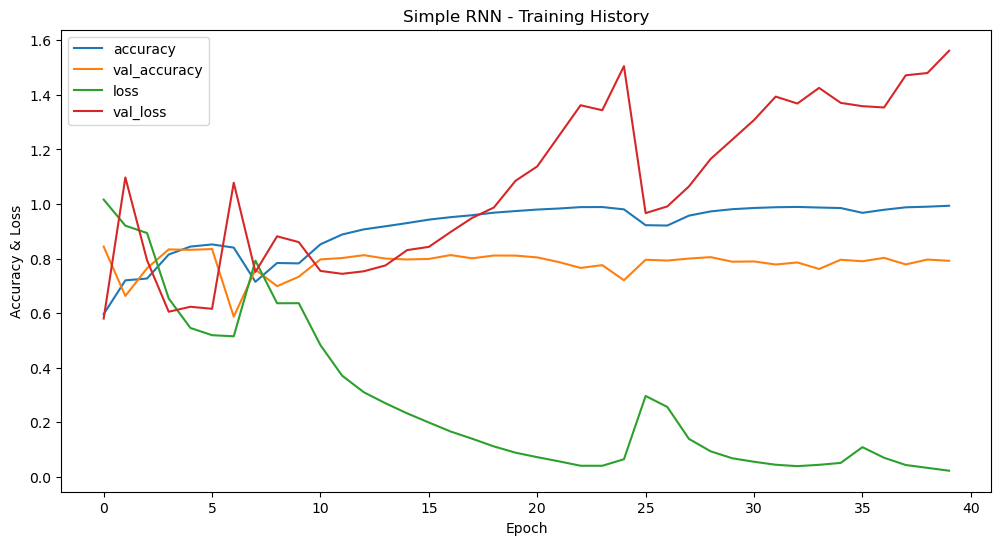

In [8]:
# Plot the training history
import matplotlib.pyplot as plt

def plot_history(history, name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{name} - Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy & Loss')
    plt.legend()
    plt.show()
    
plot_history(simple_rnn_history, "Simple RNN")

# 9. Create an Improved Simple RNN Model

In [13]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN,BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

def create_improved_simple_rnn():
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        SimpleRNN(128, return_sequences=True),
        SimpleRNN(128, return_sequences=True),
        SimpleRNN(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))
    ])
    return model

# Updated compile_and_fit function
def compile_and_fit(model, name):
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_padded, y_train_categorical,
        epochs=40,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )
    return history

# 10. Compile, Fit, and Evaluate the Improved Simple RNN Model

In [17]:
improved_simple_rnn_model = create_improved_simple_rnn()
improved_simple_rnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
improved_simple_rnn_history = compile_and_fit(improved_simple_rnn_model, "Improved Simple RNN")
evaluate_model(improved_simple_rnn_model, "Improved Simple RNN")

Epoch 1/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 226s 520ms/step - accuracy: 0.4873 - loss: 1.2790 - val_accuracy: 0.8284 - val_loss: 0.6692
Epoch 2/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 216s 507ms/step - accuracy: 0.8589 - loss: 0.5987 - val_accuracy: 0.8320 - val_loss: 0.6762
Epoch 3/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 220s 514ms/step - accuracy: 0.8474 - loss: 0.6002 - val_accuracy: 0.8600 - val_loss: 0.5421
Epoch 4/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 221s 518ms/step - accuracy: 0.8769 - loss: 0.4563 - val_accuracy: 0.8630 - val_loss: 0.5396
Epoch 5/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 219s 513ms/step - accuracy: 0.9047 - loss: 0.3535 - val_accuracy: 0.8287 - val_loss: 0.6525
Epoch 6/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 226s 527ms/step - accuracy: 0.9348 - loss: 0.2566 - val_accuracy: 0.8366 - val_loss: 0.7011
Epoch 7/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 210s 493ms/step - accuracy: 0.9513 - loss: 0.1871 - val_accuracy: 0.8524 - val_loss: 0.7500
Epoch 8/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 223s 524ms/step - accuracy: 0.9529 -

# 11. Plot the Training History of the Improved Simple RNN Model

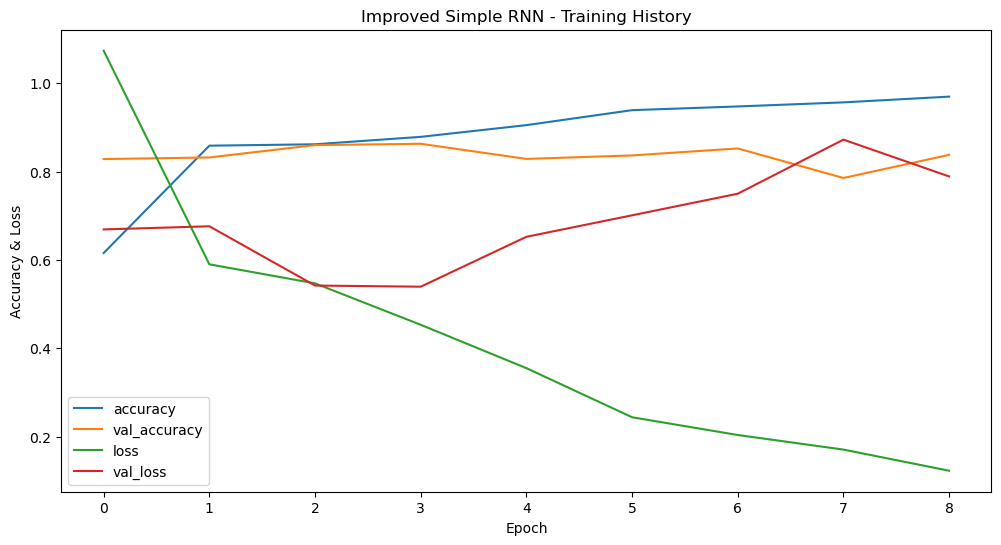

In [15]:
# Plot the training history
plot_history(improved_simple_rnn_history, "Improved Simple RNN")